## Week 6 Assignment
### John DeBlase IS620

Here is a dataset that shows a simple 2-node network:  the attendance of 18 Southern Women at 14 social events:

Brief Description: http://vlado.fmf.uni-lj.si/pub/networks/data/ucinet/ucidata.htm#davis.   [For more background information, see also:http://rpackages.ianhowson.com/cran/latentnet/man/davis.html].  Small “musty” datasets like that from this 1941 study have proven very valuable in testing and comparing new network algorithms.
Dataset: http://vlado.fmf.uni-lj.si/pub/networks/data/Ucinet/davis.dat
Python code to create dataset: https://networkx.github.io/documentation/latest/examples/algorithms/davis_club.html

What can you infer about the relationships between (1) the women, and (2) the social events?  

### Data Import

An edge list is first made using row and column information and the binding it to the incidence matrix in the text cell. This is then melted into an edge list for import into graphlab and networkx to conduct centrality analytics.

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

# create an edgelist by melting pd dataframe

names = ["EVELYN","LAURA","THERESA","BRENDA","CHARLOTTE",
             "FRANCES","ELEANOR","PEARL","RUTH","VERNE","MYRNA",
             "KATHERINE","SYLVIA","NORA","HELEN","DOROTHY","OLIVIA","FLORA"]

events = ["E1","E2","E3","E4","E5","E6","E7","E8","E9","E10","E11","E12","E13","E14"]

df = pd.read_csv("adj_matrix.dat",sep=" ", header=None, names=events)
df['names'] = names

df_melt = pd.melt(df,"names", var_name='events').sort_values("names")
df_melt = df_melt[df_melt['value'] == 1 ].reset_index(drop=True)
edge_list = df_melt[['names', 'events']]
edge_list.head(10)

,names,events
0,BRENDA,E4
1,BRENDA,E8
2,BRENDA,E7
3,BRENDA,E6
4,BRENDA,E3
5,BRENDA,E1
6,BRENDA,E5
7,CHARLOTTE,E5
8,CHARLOTTE,E3
9,CHARLOTTE,E4


### Constructing the graphs




In [2]:
## make a networkx graph for analysis 
g = nx.Graph()

for i in range(len(names)):
    g.add_node(names[i], node_type='name')

for i in range(len(events)):  # start index at end of auth node list
    g.add_node(events[i], node_type='event')
        
# connect edges 
for i in range(len(edge_list)):
    g.add_edge(edge_list.iloc[i]['names'],edge_list.iloc[i]['events'])


In [3]:
## for viz create graphlab object from nx Graph
import graphlab as gl
gl.canvas.set_target('ipynb')


def make_gl_from_nx(g):
    # simple utility that makes a graphlab graph from an nx graph
    
    viz = gl.SGraph()
    viz = viz.add_vertices([gl.Vertex(i) for i in g.nodes()])
    viz = viz.add_edges([gl.Edge(*edge) for edge in g.edges()])
    
    return viz

viz = make_gl_from_nx(g)
viz.show(vlabel='id', highlight=events, arrows=True)

This non-commercial license of GraphLab Create for academic use is assigned to john.deblase@spsmail.cuny.edu and will expire on August 29, 2017.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1475946983.log


First we look at overall degree centrality for the 2 mode network. We can see that Events 7,8,9 have a high degree of centrality. Nora Theresa and Evelyn have a high degree of centrality for the women.

In [4]:
## analysis using networkx 
deg_central = pd.DataFrame(nx.degree_centrality(g).items(),columns=['names', 'deg_central'])

nodes = g.nodes(data=True)
df_central = pd.DataFrame([(i[0], i[1]['node_type']) for i in nodes],columns=['names', 'type']).merge(deg_central, on='names')
df_central.sort_values(by='deg_central',ascending=False).head(10)


,names,type,deg_central
13,E8,event,0.451613
12,E9,event,0.387097
16,E7,event,0.322581
27,NORA,name,0.258065
17,E6,event,0.258065
10,THERESA,name,0.258065
9,E5,event,0.258065
21,EVELYN,name,0.258065
26,LAURA,name,0.225806
5,E12,event,0.225806


In order to infer deeper meaning from the graph, two weighted projections are performed, one for the women and one for the events.

Plots with colored edge weights shows two subgroups with a high degree of inter-connectivity, the first between Sylvia, Katherine, Helen and Nora, and the second between Brenda, Lauren, Evelyn and Theresa. This could indicate friendships or associations between these subgraphs.

A plot of the event edge weights is less clear, but we can see a high degree of interconnectivity between events E5, E7, E8 , and E9. This might indicate that activities at these events were similar in nature.


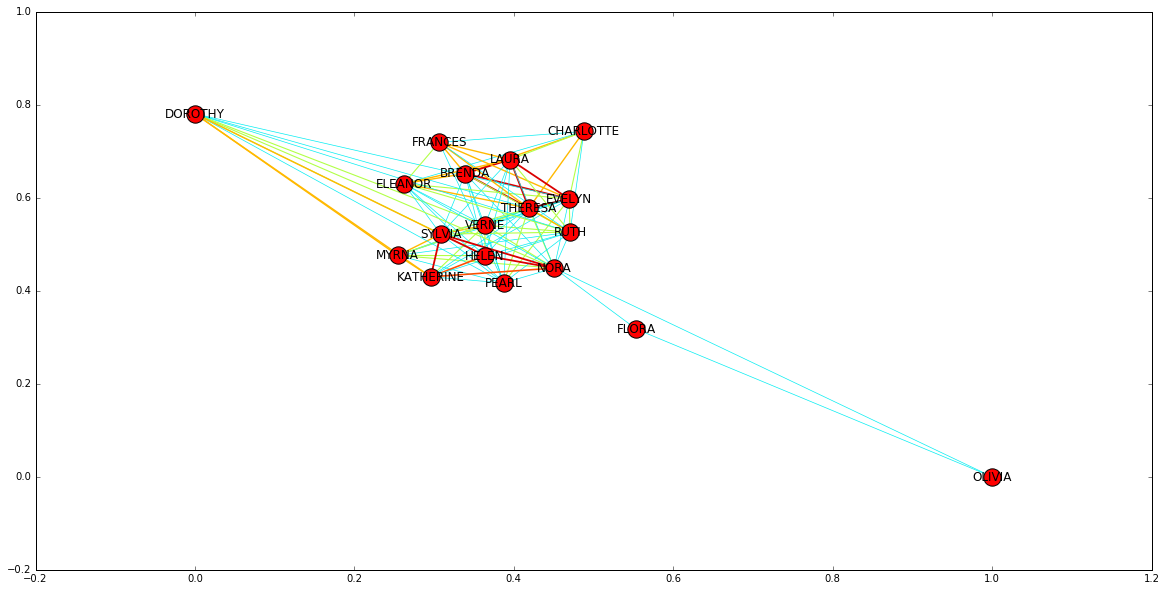

In [5]:
## weighted projection onto both names and events

from networkx.algorithms import bipartite as bi
import math

names, events = bi.sets(g)

bi.is_bipartite_node_set(g, names)

name_proj = bi.weighted_projected_graph(g, names, ratio=False) 
event_proj = bi.weighted_projected_graph(g, events, ratio=False)

plt.figure(figsize=(20,10))

# Based on code from Social Network Analysis p. 102 
weights=[math.log(e['weight'])for f, t, e in name_proj.edges(data=True)]
e_weights=[math.log(e['weight']) for f, t, e in event_proj.edges(data=True)]

nx.draw_networkx(name_proj, with_labels=True,width=weights, edge_color=weights)



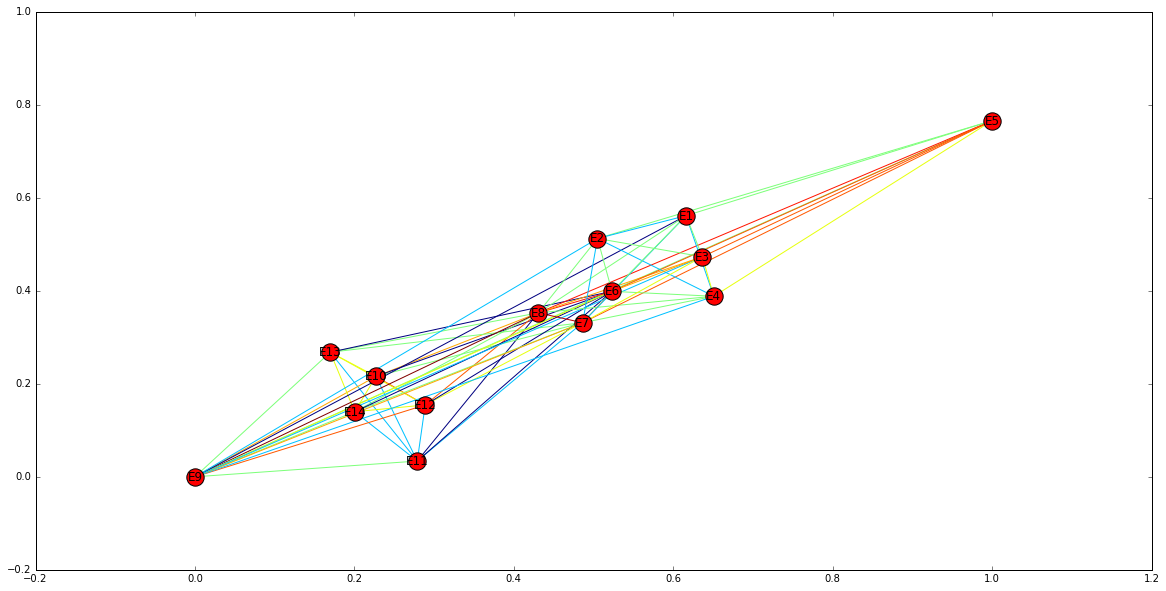

In [6]:
plt.figure(figsize=(20,10))
nx.draw_networkx(event_proj, with_labels=True, edge_color=e_weights)

For the women, we can use eigenvector centrality to look at the influence of each node in the network and betweenness centrality to quantify the control of communication each woman had in the network. These measures could infer who were the most influential members of the group.

For events, a pagerank measure is used to calculate the most visited events. Events that were well attended would have more of an impact on the network and allow for greater communication amongst the women.



In [7]:
# calculate eigenvector centrality and betweeness centrality for name_proj
eig = nx.eigenvector_centrality(name_proj)  
bet = nx.betweenness_centrality(name_proj)  
# calculate pagerank... most important events
pr = nx.pagerank(event_proj)

# dataframes for plotting
bet_df = pd.DataFrame(bet.items(), columns=['name', 'betweenness'])
names_bet_eigen = pd.DataFrame(eig.items(), columns=['name', 'eigen']).merge(bet_df, on='name')
pr_df = pd.DataFrame(pr.items(),columns=['event', 'pagerank'])


The plots below allow a comparison between centrality measurements for the weighted projections. 

Theresa, Evelyn and Sylvia seem to have the most influence amongst women in the network with high eigenvector and betweenness scores. 

Events 7,8,9 were the most popular events with the highest pagerank scores.  


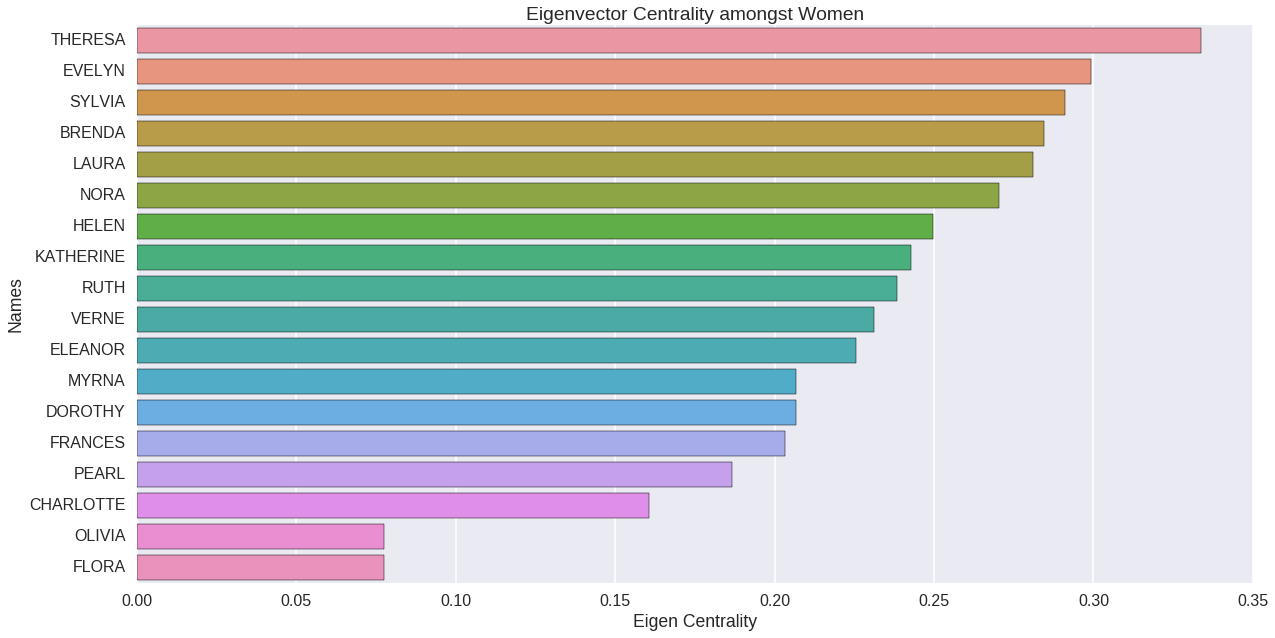

In [12]:
import seaborn as sns

sns.set_context("poster")
plt.figure(figsize=(20, 10))
ax = sns.barplot(x="eigen", y="name", data=names_bet_eigen.sort_values('eigen',ascending=False))
ax.set_title('Eigenvector Centrality amongst Women')
ax.set(xlabel='Eigen Centrality', ylabel='Names')

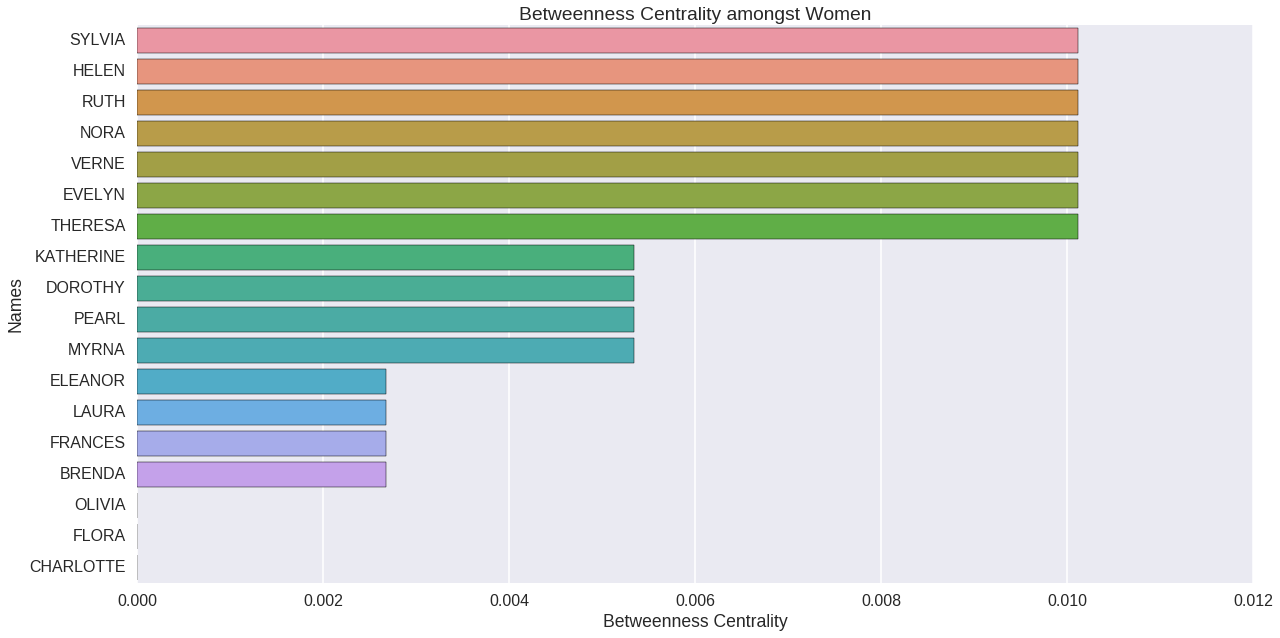

In [9]:
sns.set_context("poster")
plt.figure(figsize=(20, 10))
ax = sns.barplot(x="betweenness", y="name", data=names_bet_eigen.sort_values('betweenness',ascending=False))
ax.set_title('Betweenness Centrality amongst Women')
ax.set(xlabel='Betweenness Centrality', ylabel='Names')

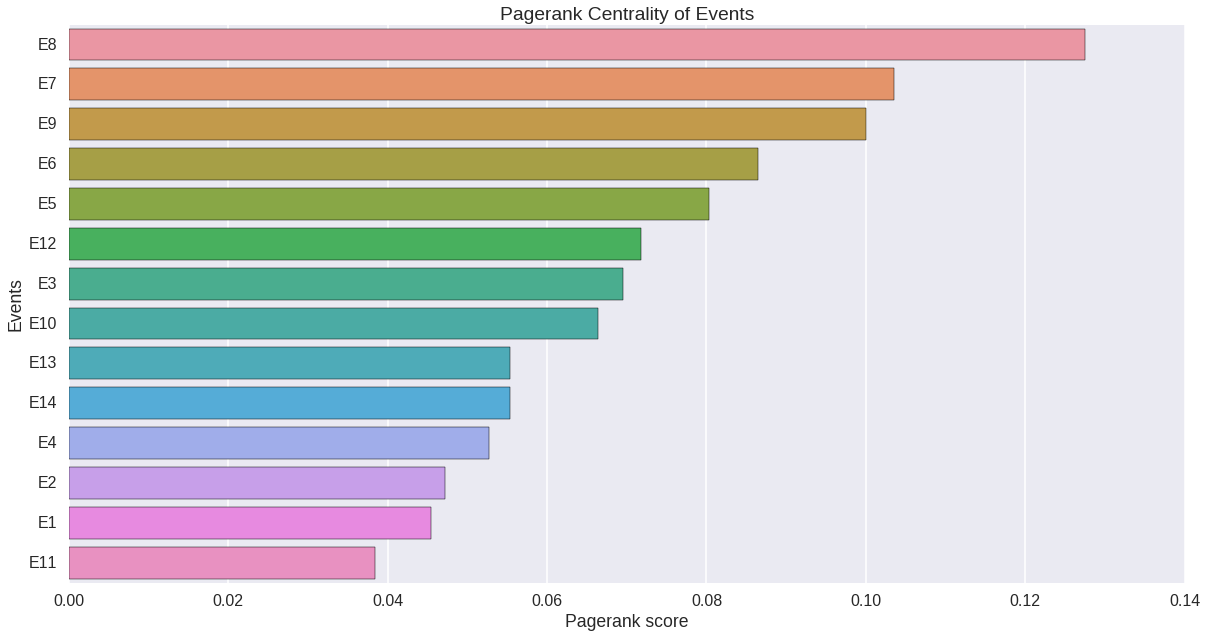

In [10]:
sns.set_context("poster")
plt.figure(figsize=(20, 10))
ax = sns.barplot(x="pagerank", y="event", data=pr_df.sort_values('pagerank',ascending=False))
ax.set_title('Pagerank Centrality of Events')
ax.set(xlabel='Pagerank score', ylabel='Events')

In [11]:
viz2 = make_gl_from_nx(name_proj)
viz3 = make_gl_from_nx(event_proj)

viz2.show(vlabel='id',highlight=['SYLVIA', 'EVELYN', 'THERESA'], arrows=True)
viz3.show(vlabel='id',highlight=['E7', 'E8', 'E9'], arrows=True)